In [26]:
%pylab inline
from IPython.display import Image
import os.path as op
import nibabel as nb
data_dir = '/home/jovyan/work/data/ds000114/'

def plot_nii(in_file):
    nb.load(in_file).orthoview()

Populating the interactive namespace from numpy and matplotlib


# Task 1: Run both T1s through a single BET interface

Hint: use `nipype.pipeline.engine.MapNode`

In [2]:
from nipype.pipeline.engine import MapNode
from nipype.interfaces import fsl

bet_node = MapNode(fsl.BET(), name='bet', iterfield=['in_file'])
bet_node.inputs.in_file = [
    op.join(data_dir, 'sub-01', 'anat', 'sub-01_T1w.nii.gz'),
    op.join(data_dir, 'sub-02', 'anat', 'sub-02_T1w.nii.gz'),
]

In [3]:
res = bet_node.run()
res.outputs.out_file

170330-18:20:37,324 workflow INFO:
	 Executing node bet in dir: /tmp/tmp74lwaj0z/bet
170330-18:20:37,351 workflow INFO:
	 Executing node _bet0 in dir: /tmp/tmp74lwaj0z/bet/mapflow/_bet0
170330-18:20:37,373 workflow INFO:
	 Running: bet /home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz /tmp/tmp74lwaj0z/bet/mapflow/_bet0/sub-01_T1w_brain.nii.gz
170330-18:20:43,533 workflow INFO:
	 Executing node _bet1 in dir: /tmp/tmp74lwaj0z/bet/mapflow/_bet1
170330-18:20:43,545 workflow INFO:
	 Running: bet /home/jovyan/work/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz /tmp/tmp74lwaj0z/bet/mapflow/_bet1/sub-02_T1w_brain.nii.gz


['/tmp/tmp74lwaj0z/bet/mapflow/_bet0/sub-01_T1w_brain.nii.gz',
 '/tmp/tmp74lwaj0z/bet/mapflow/_bet1/sub-02_T1w_brain.nii.gz']

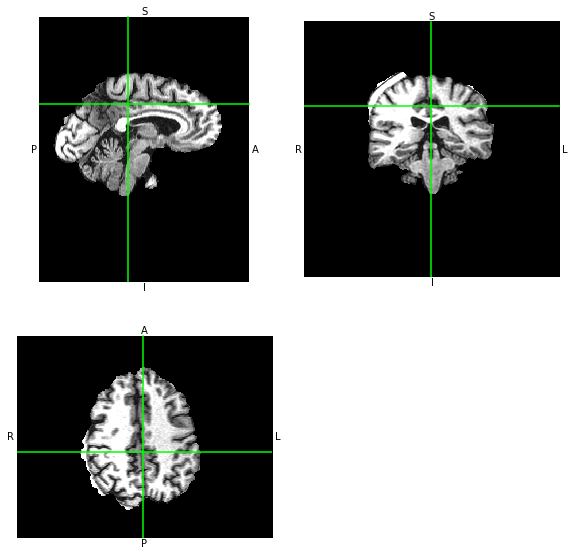

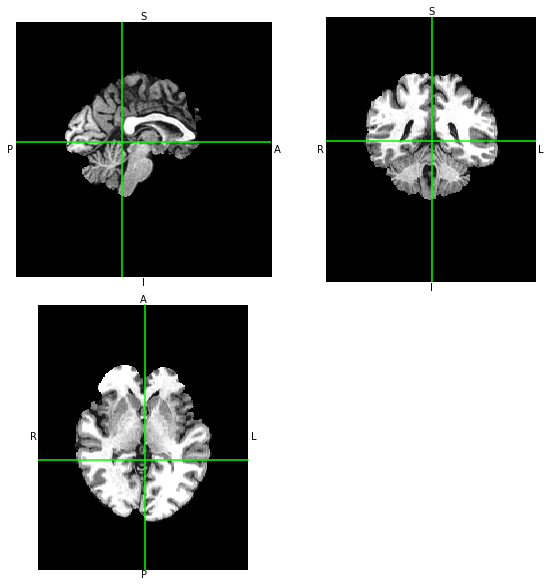

In [4]:
plot_nii(res.outputs.out_file[0])
plot_nii(res.outputs.out_file[1])

# Task 2: Run both subjects' functional through MCFLIRT
Hint: iterables + `MapNodes`

In [5]:
# Solution 1: only MapNode
import glob
mcflirt_node = MapNode(fsl.MCFLIRT(), name='mcflirt', iterfield=['in_file'])
mcflirt_node.inputs.in_file = glob.glob(op.join(data_dir, 'sub-01', 'func', '*_bold.nii.gz')) + \
    glob.glob(op.join(data_dir, 'sub-02', 'func', '*_bold.nii.gz'))
res = mcflirt_node.run()
res.outputs.out_file

170330-18:20:48,793 workflow INFO:
	 Executing node mcflirt in dir: /tmp/tmpflw8wf7w/mcflirt
170330-18:20:48,832 workflow INFO:
	 Executing node _mcflirt0 in dir: /tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt0
170330-18:20:48,847 workflow INFO:
	 Running: mcflirt -in /home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz -out /tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt0/sub-01_task-fingerfootlips_bold_mcf.nii.gz
170330-18:21:33,370 workflow INFO:
	 Executing node _mcflirt1 in dir: /tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt1
170330-18:21:33,383 workflow INFO:
	 Running: mcflirt -in /home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-linebisection_bold.nii.gz -out /tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt1/sub-01_task-linebisection_bold_mcf.nii.gz
170330-18:22:30,170 workflow INFO:
	 Executing node _mcflirt2 in dir: /tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt2
170330-18:22:30,182 workflow INFO:
	 Running: mcflirt -in /home/jovyan/work/data/ds000114/sub-02/func/sub-

['/tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt0/sub-01_task-fingerfootlips_bold_mcf.nii.gz',
 '/tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt1/sub-01_task-linebisection_bold_mcf.nii.gz',
 '/tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt2/sub-02_task-fingerfootlips_bold_mcf.nii.gz',
 '/tmp/tmpflw8wf7w/mcflirt/mapflow/_mcflirt3/sub-02_task-linebisection_bold_mcf.nii.gz']

In [6]:
# Solution 2: iterables + MapNode
from nipype import Workflow, Node
from nipype.interfaces.utility import Function

def _get_bolds(subject_id, data_dir):
    import glob
    import os.path as op
    return glob.glob(op.join(data_dir, 'sub-%s' % subject_id, 'func', '*_bold.nii.gz'))

dg_node = Node(Function(input_names=['subject_id', 'data_dir'], output_names=['out_files'], function=_get_bolds),
               name='datagrabber')
mcflirt_node = MapNode(fsl.MCFLIRT(), name='bet', iterfield=['in_file'])

wf = Workflow('task2')
wf.base_dir = 'workdir_task2'
wf.connect(dg_node, 'out_files', mcflirt_node, 'in_file')

dg_node.iterables = ('subject_id', ['01', '02'])
dg_node.inputs.data_dir = data_dir
wf.run()

170330-18:24:11,5 workflow INFO:
	 Workflow task2 settings: ['check', 'execution', 'logging']
170330-18:24:11,23 workflow INFO:
	 Running serially.
170330-18:24:11,27 workflow INFO:
	 Executing node datagrabber.aI.a1 in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/workdir_task2/task2/_subject_id_02/datagrabber
170330-18:24:11,37 workflow INFO:
170330-18:24:11,61 workflow INFO:
	 Executing node bet.a1 in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/workdir_task2/task2/_subject_id_02/bet
170330-18:24:11,91 workflow INFO:
	 Executing node datagrabber.aI.a0 in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/workdir_task2/task2/_subject_id_01/datagrabber
170330-18:24:11,103 workflow INFO:
170330-18:24:11,119 workflow INFO:
	 Executing node bet.a0 in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/workdir_task2/task2/_subject_id_01/bet


# Task 3: Get the number of subjects using bids
Hint: [notebook](https://github.com/nipy/workshops/blob/master/170327-nipype/notebooks/basic-bids/basic_data_input_bids.ipynb)

In [7]:
from bids.grabbids import BIDSLayout
layout = BIDSLayout(data_dir)
print('Number of subjects is %d' % len(layout.get_subjects()))

Number of subjects is 2


# Task 4: Use a function node to get T1w + EPIs using bids


In [8]:
def get_info(subject_id, dataset_dir):
    from bids.grabbids import BIDSLayout
    layout = BIDSLayout(dataset_dir)
    t1w = [f.filename 
           for f in layout.get(type='T1w', subject=subject_id, extensions=['nii', 'nii.gz'])]
    epi = [f.filename for f in layout.get(type='bold', subject=subject_id, extensions=['nii', 'nii.gz'])]
    return t1w, epi

In [9]:
# Test get_info:
print(get_info('01', data_dir))
print(get_info('0[12]', data_dir))

(['/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz'], ['/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-linebisection_bold.nii.gz'])
(['/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', '/home/jovyan/work/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz'], ['/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-linebisection_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-02/func/sub-02_task-fingerfootlips_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-02/func/sub-02_task-linebisection_bold.nii.gz'])


In [10]:
node_bids = Node(Function(input_names=['subject_id', 'dataset_dir'], output_names=['t1w', 'epi'],
                          function=get_info), name='bids_ds')
node_bids.inputs.subject_id = '0[12]'
node_bids.inputs.dataset_dir = data_dir

# Test this node
res = node_bids.run()
print(res.outputs.t1w)
print(res.outputs.epi)

170330-18:24:14,824 workflow INFO:
	 Executing node bids_ds in dir: /tmp/tmpkruxftdl/bids_ds
['/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', '/home/jovyan/work/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz']
['/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-linebisection_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-02/func/sub-02_task-fingerfootlips_bold.nii.gz', '/home/jovyan/work/data/ds000114/sub-02/func/sub-02_task-linebisection_bold.nii.gz']


# Task 5: A workflow with an input node and aggregating all before.

In [11]:
# We will need this little function
def _flatten(inlist):
    return [el for l in inlist for el in l]

print(_flatten([[1, 2], [3], [4, 5]]))

[1, 2, 3, 4, 5]


170330-18:34:34,998 workflow INFO:
	 Generated workflow graph: nipypework/task_5/graph.dot.png (graph2use=hierarchical, simple_form=True).


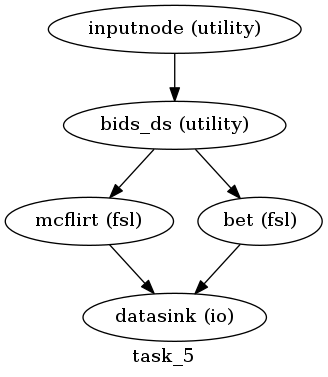

In [27]:
from nipype.interfaces.utility import IdentityInterface, Rename
from nipype.interfaces.io import DataSink

inputs_node = Node(IdentityInterface(
    fields=['subject_id']), name='inputnode'
)
bids_node = MapNode(Function(input_names=['subject_id', 'dataset_dir'], output_names=['t1w', 'epi'],
                             function=get_info),
                    name='bids_ds', 
                    iterfield=['subject_id']
)
bet_node = MapNode(fsl.BET(), name='bet', iterfield=['in_file'])
mcflirt_node = MapNode(fsl.MCFLIRT(), name='mcflirt', iterfield=['in_file'])

ds_node = Node(DataSink(
    base_directory='/home/jovyan/work/workshops/170327-'
                   'nipype/notebooks/nipype_101_tasks/nipype_outputs'),
               name='datasink')

wf = Workflow('task_5')
wf.base_dir = 'nipypework'
wf.connect(inputs_node, 'subject_id', bids_node, 'subject_id')
wf.connect(bids_node, ('t1w', _flatten), bet_node, 'in_file')
wf.connect(bids_node, ('epi', _flatten), mcflirt_node, 'in_file')
wf.connect(bet_node, 'out_file', ds_node, 't1w')
wf.connect(mcflirt_node, 'out_file', ds_node, 'epi')

Image(wf.write_graph())

In [28]:
# Time to run it
wf.inputs.inputnode.subject_id = ['01', '02']
wf.inputs.bids_ds.dataset_dir = data_dir
wf.run()

170330-18:34:35,813 workflow INFO:
	 Workflow task_5 settings: ['check', 'execution', 'logging']
170330-18:34:35,832 workflow INFO:
	 Running serially.
170330-18:34:35,837 workflow INFO:
	 Executing node bids_ds in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/nipypework/task_5/bids_ds
170330-18:34:35,869 workflow INFO:
	 Executing node bet in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/nipypework/task_5/bet
170330-18:34:35,905 workflow INFO:
	 Executing node mcflirt in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/nipypework/task_5/mcflirt
170330-18:34:35,951 workflow INFO:
	 Executing node datasink in dir: /home/jovyan/work/workshops/170327-nipype/notebooks/nipype_101_tasks/nipypework/task_5/datasink


In [29]:
!tree nipype_outputs/

nipype_outputs/
├── epi
│   ├── _mcflirt0
│   │   └── sub-01_task-fingerfootlips_bold_mcf.nii.gz
│   ├── _mcflirt1
│   │   └── sub-01_task-linebisection_bold_mcf.nii.gz
│   ├── _mcflirt2
│   │   └── sub-02_task-fingerfootlips_bold_mcf.nii.gz
│   └── _mcflirt3
│       └── sub-02_task-linebisection_bold_mcf.nii.gz
└── t1w
    ├── _bet0
    │   └── sub-01_T1w_brain.nii.gz
    └── _bet1
        └── sub-02_T1w_brain.nii.gz

8 directories, 6 files
